Playground for testing the translation in pytorch ensuring differentiability
# First Approach

In [2]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from torchvision import datasets, transforms
import torch.nn.functional as F
from PIL import Image
import json

In [3]:
im = Image.open('combined/5373.jpg')
im = im.resize((1440, 2560), Image.Resampling.LANCZOS)

In [4]:
with open("combined/5373.json", "r") as f:
    image_json = json.load(f)

In [5]:
def get_all_bounding_boxes(item):
    all_boxes = []
    if "bounds" in item.keys():
        all_boxes.append(item["bounds"])
    if "children" in item.keys():
        for child in item["children"]:
            for box in get_all_bounding_boxes(child):
                all_boxes.append(box)
    return all_boxes
"""
returns a list of the segments and a list of coordinates
"""
def segment(image: np.ndarray, rico_json: dict)->[list,list]:
    boxes = get_all_bounding_boxes(rico_json["activity"]["root"])
    segments = []
    coordinates = []
    for box in boxes:
        anchor_point = (box[0],box[1])
        width = box[2]-box[0]
        height = box[3]-box[1]
        cropped_image = im.crop((box[0],box[1],box[2],box[3]))
        # Only include segments that are less than 90% the size of the original image
        if (width*height) < 0.9*(im.size[0]*im.size[1]):
            segments.append(cropped_image)
            coordinates.append((box[0],box[1]))
    return [segments,coordinates]

In [6]:
segment_0 =  segment(im,image_json)[0][1]

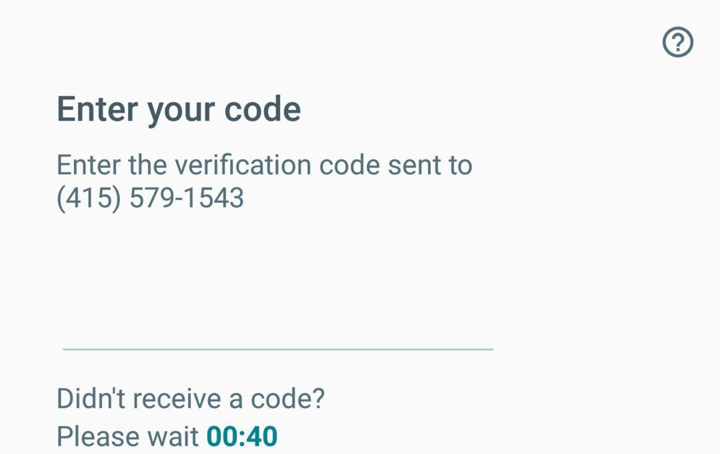

In [7]:
display(segment_0.resize((int(segment_0.size[0]/2), int(segment_0.size[1]/2))))

In [8]:
grid_location_x, grid_location_y = -0.5,0.0
rotation_simple = np.array([[1,0, grid_location_x],
                           [ 0,1, grid_location_y]])

In [9]:
transform = transforms.Compose([transforms.ToTensor()])
tensor = transform(im)

/Users/mowoe/Documents/bachelorthesis/venv/lib/python3.11/site-packages/torch/nn/functional.py:4316: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn(


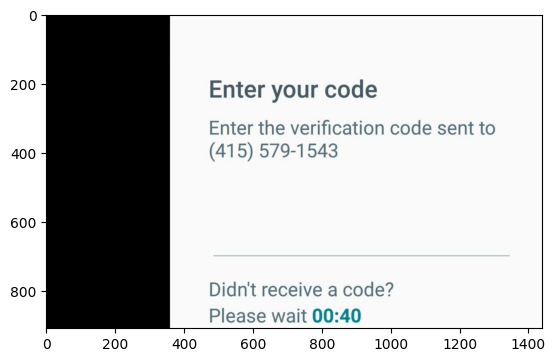

In [10]:
dtype =  torch.FloatTensor
rotation_simple_tensor = torch.as_tensor(rotation_simple)[None]

grid = F.affine_grid(rotation_simple_tensor, transform(segment_0).unsqueeze(0).size(),align_corners=False).type(dtype)

x = F.grid_sample(transform(segment_0).unsqueeze(0), grid)

plt.imshow(x[0].permute(1, 2, 0))
plt.show()

# Second Approach
from [https://stackoverflow.com/questions/69752807/differentiable-affine-transformation-on-patches-of-images-in-pytorch](https://stackoverflow.com/questions/69752807/differentiable-affine-transformation-on-patches-of-images-in-pytorch)

In [11]:
x = torch.zeros(9,9,dtype=float, requires_grad=False)

In [12]:
x

tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0.]], dtype=torch.float64)

In [13]:
values = torch.randint(0, 100, (4,1), dtype=float, requires_grad=True)

In [14]:
values

tensor([[56.],
        [37.],
        [75.],
        [39.]], dtype=torch.float64, requires_grad=True)

In [19]:
i, j = torch.Tensor([[3],
         [4],
         [5],
         [6]]).int().requires_grad_(), torch.Tensor([[5],
         [5],
         [5],
         [5]]).int()

RuntimeError: only Tensors of floating point dtype can require gradients

In [16]:
i,j

(tensor([[3],
         [4],
         [5],
         [6]], dtype=torch.int32),
 tensor([[5],
         [5],
         [5],
         [5]], dtype=torch.int32))

In [17]:
x.index_put(indices=(i, j), values=values)

tensor([[ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0., 56.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0., 37.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0., 75.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0., 39.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.]], dtype=torch.float64,
       grad_fn=<IndexPutBackward0>)

In [26]:
# Create a tensor
x = torch.zeros(3, 3, dtype=torch.int64)
print
# Assign values to specific indices
indices = torch.tensor([[0, 1], [1, 2]])
values = torch.tensor([3, 4])
x.scatter_(0, indices, values)

print(x)

IndexError: Dimension out of range (expected to be in range of [-1, 0], but got 1)